In [1]:
import os
configured_cwd = False
def configure_cwd():
    os.chdir("../..")
    configured_cwd = True 
if not configured_cwd:
    configure_cwd()

In [2]:
import pandas as pd
import ccxt
import numpy as np
from pathlib import Path
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, LSTM, Dropout

import matplotlib.pyplot as plt

from utilities.backtesting import (
    basic_single_asset_backtest,
    plot_wallet_vs_asset,
    get_metrics,
)
from utilities.get_data import get_historical_from_db



2022-10-22 13:34:21.863959: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-22 13:34:21.863975: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [9]:
learn_period = 7
predict_number_of_units = 1

models_dir_path = Path(
    f"/media/mustafa-cleverdoc/A286EA2086E9F527/DATA/back_test_tools/models/lstm/{learn_period}-{predict_number_of_units}"
)
os.makedirs(models_dir_path, exist_ok=True)

data_dir_path = Path(
    "/media/mustafa-cleverdoc/A286EA2086E9F527/DATA/back_test_tools/data"
)
pair = "ADA/USDT"
tf = "1d"

df = get_historical_from_db(ccxt.binance(), pair, tf, path=data_dir_path)

training_set = df.copy().loc[:"2020"]
test_set = df.copy().loc["2021":]

In [10]:
sc = MinMaxScaler(feature_range=(0, 1))
training_set_scaled = sc.fit_transform(training_set["close"].values.reshape(-1, 1))
X_train = []
y_train = []

In [11]:
for i in range(learn_period, len(training_set)):
    X_train.append(training_set_scaled[i - learn_period : i, 0])
    y_train.append(training_set_scaled[i: i + predict_number_of_units, 0])

In [12]:
y_train = [sample for sample in y_train if len(sample) == predict_number_of_units]
X_train = X_train[:len(y_train)]

X_train, y_train = np.array(X_train), np.array(y_train)


In [13]:
X_train = X_train.reshape(*X_train.shape[0:2], 1)

In [14]:
models_URI_names = os.listdir(models_dir_path)
if models_URI_names:
    model_URI_name = models_URI_names[-1]
    regressor = load_model(models_dir_path / model_URI_name)
else:
    epochs = 50
    regressor = Sequential()
    regressor.add(
        LSTM(units=50, return_sequences=True, input_shape=X_train.shape[-2:])
    )
    regressor.add(Dropout(0.2))
    regressor.add(LSTM(units=50, return_sequences=True))
    regressor.add(Dropout(0.2))
    regressor.add(LSTM(units=50, return_sequences=True))
    regressor.add(Dropout(0.2))
    regressor.add(LSTM(units=50))
    regressor.add(Dropout(0.2))
    regressor.add(Dense(units=predict_number_of_units))
    regressor.compile(optimizer="adam", loss="mean_squared_error")
    regressor.fit(X_train, y_train, epochs=epochs, batch_size=32)
    regressor.save(models_dir_path / f"model_{epochs}")


Epoch 1/50
31/31 [==============================] - 5s 10ms/step - loss: 0.0190
Epoch 2/50
31/31 [==============================] - 0s 10ms/step - loss: 0.0035
Epoch 3/50
31/31 [==============================] - 0s 9ms/step - loss: 0.0025
Epoch 4/50
31/31 [==============================] - 0s 10ms/step - loss: 0.0025
Epoch 5/50
31/31 [==============================] - 0s 9ms/step - loss: 0.0022
Epoch 6/50
31/31 [==============================] - 0s 9ms/step - loss: 0.0024
Epoch 7/50
31/31 [==============================] - 0s 10ms/step - loss: 0.0019
Epoch 8/50
31/31 [==============================] - 0s 11ms/step - loss: 0.0021
Epoch 9/50
31/31 [==============================] - 0s 10ms/step - loss: 0.0024
Epoch 10/50
31/31 [==============================] - 0s 10ms/step - loss: 0.0021
Epoch 11/50
31/31 [==============================] - 0s 11ms/step - loss: 0.0019
Epoch 12/50
31/31 [==============================] - 0s 9ms/step - loss: 0.0021
Epoch 13/50
31/31 [======================

INFO:tensorflow:Assets written to: /media/mustafa-cleverdoc/A286EA2086E9F527/DATA/back_test_tools/models/lstm/7-1/model_50/assets


INFO:tensorflow:Assets written to: /media/mustafa-cleverdoc/A286EA2086E9F527/DATA/back_test_tools/models/lstm/7-1/model_50/assets


In [15]:
real_stock_price = test_set["close"].values
inputs = test_set["close"].values
inputs = np.concatenate([np.array([0]*learn_period), inputs], axis=0)
inputs = inputs.reshape(-1, 1)
inputs = sc.fit_transform(inputs)
X_test = []
for i in range(learn_period, len(test_set) + learn_period):
    X_test.append(inputs[i - learn_period : i, 0])


In [16]:
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

21/21 [==============================] - 1s 3ms/step


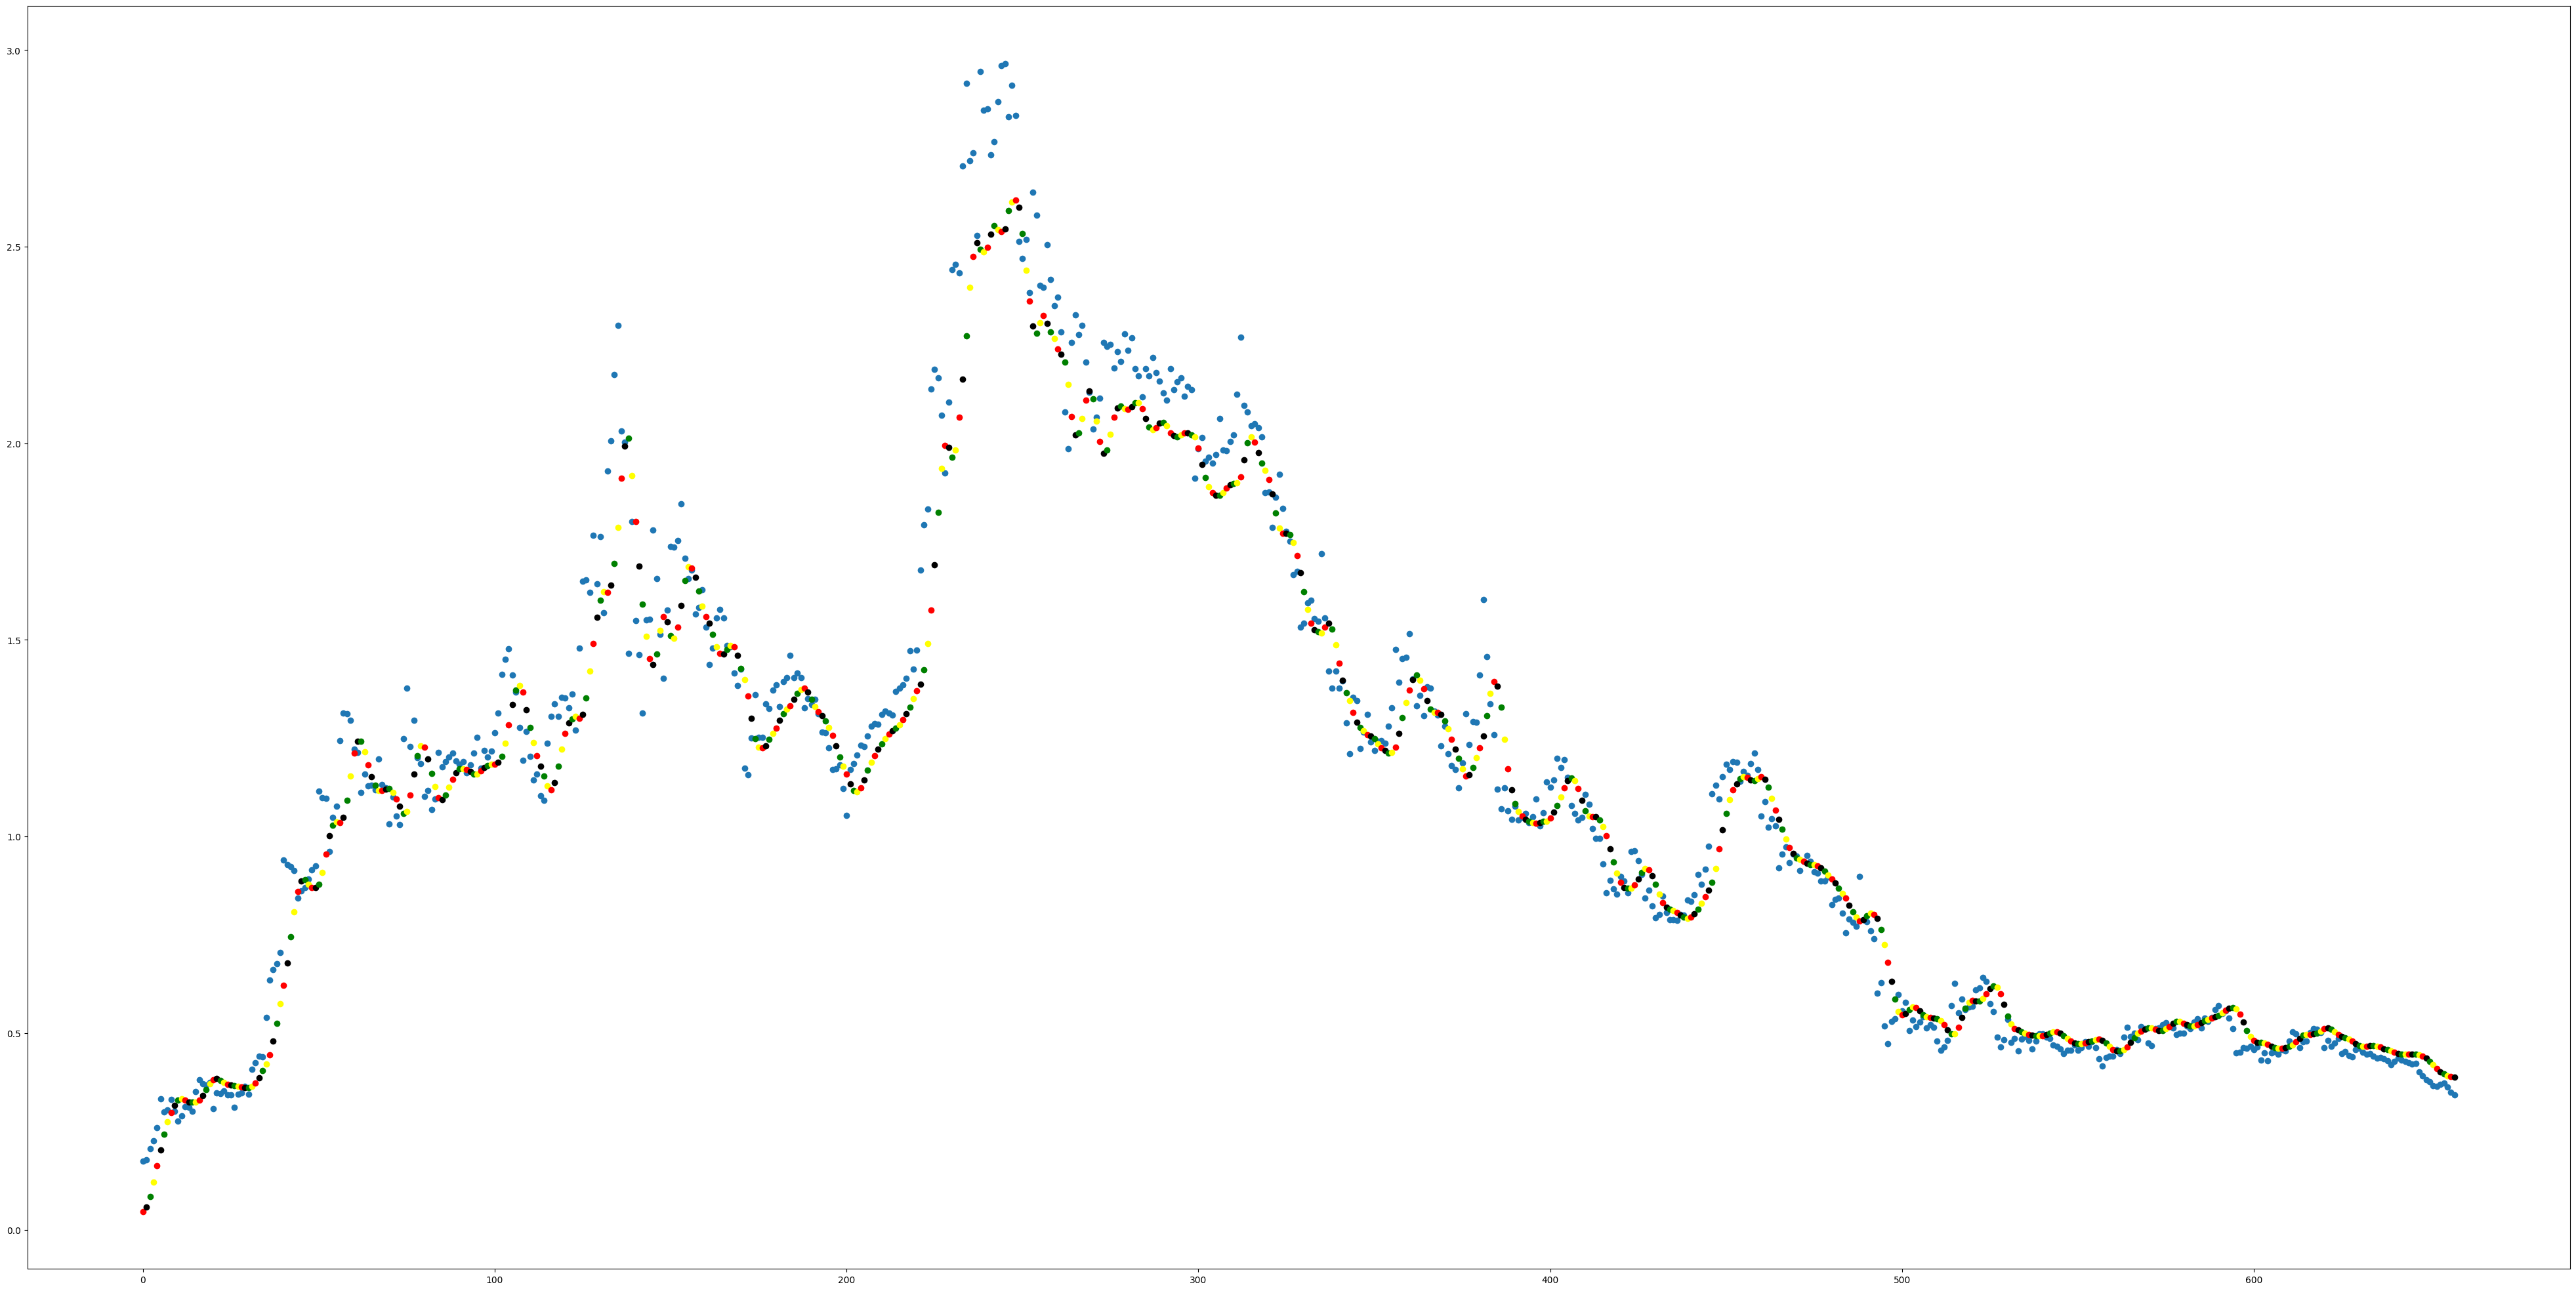

In [17]:
plt.figure(figsize=(50, 25))
plt.scatter(range(len(real_stock_price)), real_stock_price)
colors = {
    0: "red",
    1: "black",
    2: "green",
    3: "yellow"
}
for i in range(len(predicted_stock_price)):
    plt.scatter(range(i, i+predict_number_of_units), predicted_stock_price[i, :], color=colors[i%4], label=f"{pair} Predicted Price")
plt.show()

In [18]:
reduced_predicted_stock_price = []
for i in range(len(predicted_stock_price)):
    if i%predict_number_of_units == 0:
        reduced_predicted_stock_price.append(predicted_stock_price[i])
reduced_predicted_stock_price = np.array(reduced_predicted_stock_price)
reduced_predicted_stock_price = reduced_predicted_stock_price.reshape(-1)

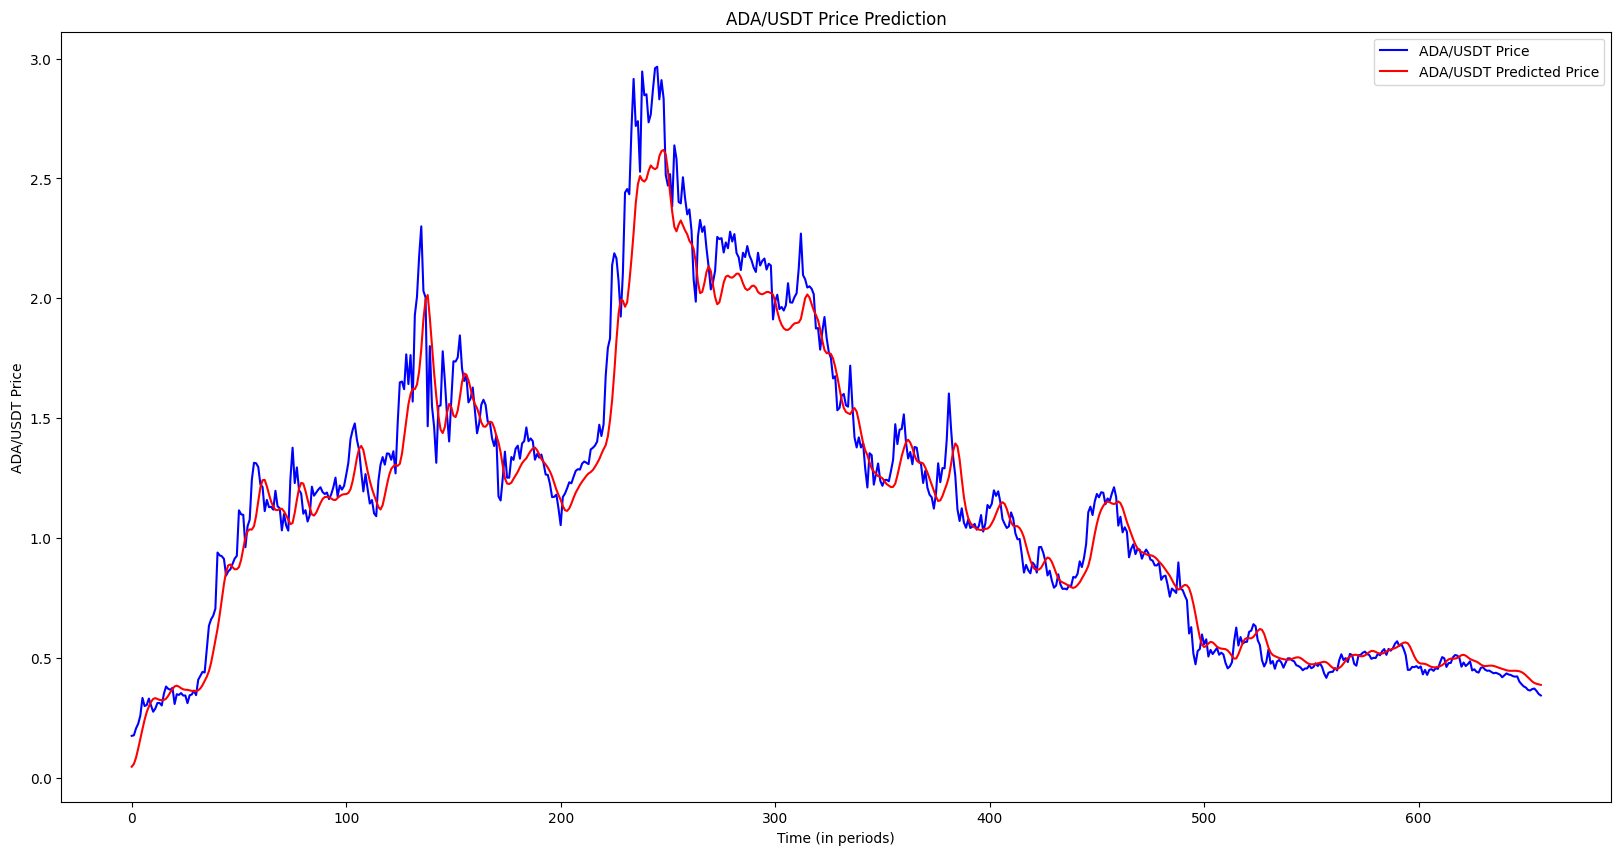

In [19]:
plt.figure(figsize=(20, 10))
plt.plot(real_stock_price, color="blue", label=f"{pair} Price")
plt.plot(reduced_predicted_stock_price, color="red", label=f"{pair} Predicted Price")
plt.title(f"{pair} Price Prediction")
plt.xlabel("Time (in periods)")
plt.ylabel(f"{pair} Price")
plt.legend()
plt.show()

the prediction lags behind the true value because the series is autoregressive (i.e. a strong way to predict tomorrow’s value is “It will be about the same as today”). Model therefore corrects itself with the new information when it misses a big jump. In other words, if the price jumps one day and model does not predict that, it has learned to take into account the higher price for the prediction of the next day’s price.

# Next cells assume LSTM outputs a single element

In [21]:
df["predicted"] = 0
df["predicted"].iloc[
    -len(predicted_stock_price.flatten()) :
] = predicted_stock_price.flatten()
df["diff_close"] = df["close"].diff()
df["diff_predicted"] = df["predicted"].diff()
df["next_predicted"] = df["predicted"].shift(-1)
df["next_close"] = df["close"].shift(-1)
df["diff_predicted_next"] = df["next_predicted"] - df["predicted"]
df["diff_close_next"] = df["next_close"] - df["close"]
df["mean_evol_3"] = df["close"].shift(-3).rolling(3).mean() - df["close"]
df["mean_evol_5"] = df["close"].shift(-5).rolling(5).mean() - df["close"]
df["mean_evol_10"] = df["close"].shift(-10).rolling(10).mean() - df["close"]
df["mean_evol_20"] = df["close"].shift(-20).rolling(20).mean() - df["close"]
df


/home/mustafa-cleverdoc/PycharmProjects/backtest_tools/venv-3.9.12/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,open,high,low,close,volume,predicted,diff_close,diff_predicted,next_predicted,next_close,diff_predicted_next,diff_close_next,mean_evol_3,mean_evol_5,mean_evol_10,mean_evol_20
date,,,,,,,,,,,,,,,,
2018-04-17,0.25551,0.28800,0.23983,0.24260,67462293.24,0.000000,NaN,NaN,0.000000,0.26200,0.000000,0.01940,NaN,NaN,NaN,NaN
2018-04-18,0.24260,0.26460,0.24201,0.26200,31328095.79,0.000000,0.01940,0.000000,0.000000,0.27004,0.000000,0.00804,NaN,NaN,NaN,NaN
2018-04-19,0.26199,0.27500,0.25777,0.27004,50859980.22,0.000000,0.00804,0.000000,0.000000,0.30108,0.000000,0.03104,0.019747,NaN,NaN,NaN
2018-04-20,0.27004,0.30442,0.26648,0.30108,71084276.49,0.000000,0.03104,0.000000,0.000000,0.28668,0.000000,-0.01440,-0.015693,NaN,NaN,NaN
2018-04-21,0.30161,0.30700,0.26509,0.28668,92719842.91,0.000000,-0.01440,0.000000,0.000000,0.28160,0.000000,-0.00508,0.005990,0.001314,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-16,0.36410,0.37490,0.36380,0.37030,61182203.20,0.401797,0.00620,-0.008390,0.395536,0.37230,-0.006261,0.00200,-0.008833,NaN,NaN,NaN
2022-10-17,0.37030,0.37580,0.36600,0.37230,66215062.20,0.395536,0.00200,-0.006261,0.392079,0.36240,-0.003457,-0.00990,-0.020400,NaN,NaN,NaN
2022-10-18,0.37240,0.37430,0.35690,0.36240,95363501.10,0.392079,-0.00990,-0.003457,0.390050,0.34970,-0.002029,-0.01270,NaN,NaN,NaN,NaN


In [22]:
print(len(df.loc[(df["diff_predicted_next"] > df["diff_close"]) & (df["diff_close_next"] > 0)]))
print(len(df.loc[(df["diff_predicted_next"] > df["diff_close"]) & (df["diff_close_next"] < 0)]))
print("-------------")
print(len(df.loc[(df["diff_predicted_next"] < df["diff_close"]) & (df["diff_close_next"] < 0)]))
print(len(df.loc[(df["diff_predicted_next"] < df["diff_close"]) & (df["diff_close_next"] > 0)]))
print("-------------")
print(df.loc[(df["diff_predicted_next"] > df["diff_close"])]["diff_close_next"].mean())
print(df.loc[(df["diff_predicted_next"] > df["diff_close"])]["mean_evol_3"].mean())
print(df.loc[(df["diff_predicted_next"] > df["diff_close"])]["mean_evol_5"].mean())
print(df.loc[(df["diff_predicted_next"] > df["diff_close"])]["mean_evol_10"].mean())
print(df.loc[(df["diff_predicted_next"] > df["diff_close"])]["mean_evol_20"].mean())
print("-------------")
print(df.loc[(df["diff_predicted_next"] < df["diff_close"])]["diff_close_next"].mean())
print(df.loc[(df["diff_predicted_next"] < df["diff_close"])]["mean_evol_3"].mean())
print(df.loc[(df["diff_predicted_next"] < df["diff_close"])]["mean_evol_5"].mean())
print(df.loc[(df["diff_predicted_next"] < df["diff_close"])]["mean_evol_10"].mean())
print(df.loc[(df["diff_predicted_next"] < df["diff_close"])]["mean_evol_20"].mean())

444
375
-------------
444
379
-------------
0.0008381995133819953
0.0017257154471545118
0.002029124390243902
0.0032954692874692898
0.0047825124533001275
-------------
-0.0007379222357229648
-0.0015464030819139917
-0.0017490171149144298
-0.003025181818181814
-0.0030915453416149063


In [23]:
print(len(df.loc[(df["diff_predicted"] > 0) & (df["diff_close"] > 0)]))
print(len(df.loc[(df["diff_predicted"] > 0) & (df["diff_close"] < 0)]))
print("-------------")
print(len(df.loc[(df["diff_predicted"] < 0) & (df["diff_close"] < 0)]))
print(len(df.loc[(df["diff_predicted"] < 0) & (df["diff_close"] > 0)]))
print("-------------")
print(df.loc[(df["diff_predicted"] > 0)]["diff_close_next"].mean())
print(df.loc[(df["diff_predicted"] > 0)]["mean_evol_3"].mean())
print(df.loc[(df["diff_predicted"] > 0)]["mean_evol_5"].mean())
print(df.loc[(df["diff_predicted"] > 0)]["mean_evol_10"].mean())
print(df.loc[(df["diff_predicted"] > 0)]["mean_evol_20"].mean())
print("-------------")
print(df.loc[(df["diff_predicted"] < 0)]["diff_close_next"].mean())
print(df.loc[(df["diff_predicted"] < 0)]["mean_evol_3"].mean())
print(df.loc[(df["diff_predicted"] < 0)]["mean_evol_5"].mean())
print(df.loc[(df["diff_predicted"] < 0)]["mean_evol_10"].mean())
print(df.loc[(df["diff_predicted"] < 0)]["mean_evol_20"].mean())

151
155
-------------
175
175
-------------
0.0018813071895424798
0.005278845315904228
0.008407287581699341
0.013459676470588246
0.02154041611842105
-------------
-0.0011600284900284863
-0.0036313658070676884
-0.005939550432276659
-0.009787263157894735
-0.015091022455089809


In [24]:
class lstm_strat:
    def __init__(
        self,
        df,
        use_short=True,
        strat=0,
    ):
        self.df = df
        self.use_short = use_short
        self.strat = strat

    def populate_indicators(self, show_log=False):
        # -- Clear dataset --
        df = self.df
        df.drop(
            columns=df.columns.difference(
                ["open", "high", "low", "close", "volume", "predicted"]
            ),
            inplace=True,
        )

        # -- Populate indicators --
        df["diff_close"] = df["close"].diff()
        df["diff_predicted"] = df["predicted"].diff()
        df["next_predicted"] = df["predicted"].shift(-1)
        df["diff_predicted_next"] = df["next_predicted"] - df["predicted"]

        # -- Log --
        if show_log:
            print(df)

        self.df = df
        return self.df

    def populate_buy_sell(self, show_log=False):
        df = self.df
        # -- Initiate populate --
        df["open_long_market"] = False
        df["close_long_market"] = False
        df["open_short_market"] = False
        df["close_short_market"] = False

        if self.strat == 0:
            # -- Populate open long market --
            df.loc[(df["diff_predicted"] > 0), "open_long_market"] = True

            # -- Populate close long market --
            df.loc[(df["diff_predicted"] < 0), "close_long_market"] = True

            if self.use_short:
                # -- Populate open short market --
                df.loc[(df["diff_predicted"] < 0), "open_short_market"] = True

                # -- Populate close short market --
                df.loc[(df["diff_predicted"] > 0), "close_short_market"] = True

        elif self.strat == 1:
            # -- Populate open long market --
            df.loc[
                (df["diff_predicted_next"] > df["diff_close"]), "open_long_market"
            ] = True

            # -- Populate close long market --
            df.loc[
                (df["diff_close"] > df["diff_predicted_next"]), "close_long_market"
            ] = True

            if self.use_short:
                # -- Populate open short market --
                df.loc[
                    (df["diff_close"] > df["diff_predicted_next"]), "open_short_market"
                ] = True

                # -- Populate close short market --
                df.loc[
                    (df["diff_predicted_next"] > df["diff_close"]), "close_short_market"
                ] = True

        # -- Log --
        if show_log:
            print("Open LONG length :", len(df.loc[df["open_long_market"] == True]))
            print("Close LONG length :", len(df.loc[df["close_long_market"] == True]))
            print("Open SHORT length :", len(df.loc[df["open_short_market"] == True]))
            print("Close SHORT length :", len(df.loc[df["close_short_market"] == True]))

        self.df = df
        return self.df

    def run_backtest(self, initial_wallet=1000, return_type="metrics"):
        dt = self.df[:]
        wallet = initial_wallet
        maker_fee = 0
        taker_fee = 0.0007
        trades = []
        days = []
        current_day = 0
        previous_day = 0
        current_position = None

        # print("tp",take_profit_pct,"sl",stop_loss_pct)

        for index, row in dt.iterrows():

            # -- Add daily report --
            current_day = index.day
            if previous_day != current_day:
                temp_wallet = wallet
                if current_position:
                    if current_position["side"] == "LONG":
                        close_price = row["close"]
                        trade_result = (
                            close_price - current_position["price"]
                        ) / current_position["price"]
                        temp_wallet += temp_wallet * trade_result
                        fee = temp_wallet * taker_fee
                        temp_wallet -= fee
                    elif current_position["side"] == "SHORT":
                        close_price = row["close"]
                        trade_result = (
                            current_position["price"] - close_price
                        ) / current_position["price"]
                        temp_wallet += temp_wallet * trade_result
                        fee = temp_wallet * taker_fee
                        temp_wallet -= fee

                days.append(
                    {
                        "day": str(index.year)
                        + "-"
                        + str(index.month)
                        + "-"
                        + str(index.day),
                        "wallet": temp_wallet,
                        "price": row["close"],
                    }
                )
            previous_day = current_day
            if current_position:
                # -- Check for closing position --
                if current_position["side"] == "LONG":

                    # -- Close LONG market --
                    if row["close_long_market"]:
                        close_price = row["close"]
                        trade_result = (
                            close_price - current_position["price"]
                        ) / current_position["price"]
                        wallet += wallet * trade_result
                        fee = wallet * taker_fee
                        wallet -= fee
                        trades.append(
                            {
                                "open_date": current_position["date"],
                                "close_date": index,
                                "position": "LONG",
                                "open_reason": current_position["reason"],
                                "close_reason": "Market",
                                "open_price": current_position["price"],
                                "close_price": close_price,
                                "open_fee": current_position["fee"],
                                "close_fee": fee,
                                "open_trade_size": current_position["size"],
                                "close_trade_size": wallet,
                                "wallet": wallet,
                            }
                        )
                        current_position = None

                elif current_position["side"] == "SHORT":
                    # -- Close SHORT Market --
                    if row["close_short_market"]:
                        close_price = row["close"]
                        trade_result = (
                            current_position["price"] - close_price
                        ) / current_position["price"]
                        wallet += wallet * trade_result
                        fee = wallet * taker_fee
                        wallet -= fee
                        trades.append(
                            {
                                "open_date": current_position["date"],
                                "close_date": index,
                                "position": "SHORT",
                                "open_reason": current_position["reason"],
                                "close_reason": "Market",
                                "open_price": current_position["price"],
                                "close_price": close_price,
                                "open_fee": current_position["fee"],
                                "close_fee": fee,
                                "open_trade_size": current_position["size"],
                                "close_trade_size": wallet,
                                "wallet": wallet,
                            }
                        )
                        current_position = None

            # -- Check for opening position --
            else:
                # Open long market
                if row["open_long_market"]:
                    open_price = row["close"]
                    fee = wallet * taker_fee
                    wallet -= fee
                    pos_size = wallet
                    current_position = {
                        "size": pos_size,
                        "date": index,
                        "price": open_price,
                        "fee": fee,
                        "reason": "Market",
                        "side": "LONG",
                    }
                elif row["open_short_market"]:
                    open_price = row["close"]
                    fee = wallet * taker_fee
                    wallet -= fee
                    pos_size = wallet
                    current_position = {
                        "size": pos_size,
                        "date": index,
                        "price": open_price,
                        "fee": fee,
                        "reason": "Market",
                        "side": "SHORT",
                    }

        df_days = pd.DataFrame(days)
        df_days["day"] = pd.to_datetime(df_days["day"])
        df_days = df_days.set_index(df_days["day"])

        df_trades = pd.DataFrame(trades)
        df_trades["open_date"] = pd.to_datetime(df_trades["open_date"])
        df_trades = df_trades.set_index(df_trades["open_date"])

        if return_type == "metrics":
            return get_metrics(df_trades, df_days) | {
                "wallet": wallet,
                "trades": df_trades,
                "days": df_days,
            }
        else:
            return True


Period: [2021-01-01 00:00:00] -> [2022-10-20 00:00:00]
Initial wallet: 1000.0 $

--- General Information ---
Final wallet: 2822.65 $
Performance vs US dollar: 182.27 %
Sharpe Ratio: 1.06
Worst Drawdown T|D: -63.37% | -68.67%
Buy and hold performance: 96.24 %
Performance vs buy and hold: 43.84 %
Total trades on the period: 90
Global Win rate: 48.89 %
Average Profit: 2.3 %

Best trades: +118.01 % the 2021-02-01 00:00:00 -> 2021-02-17 00:00:00
Worst trades: -30.96 % the 2021-03-14 00:00:00 -> 2021-03-17 00:00:00


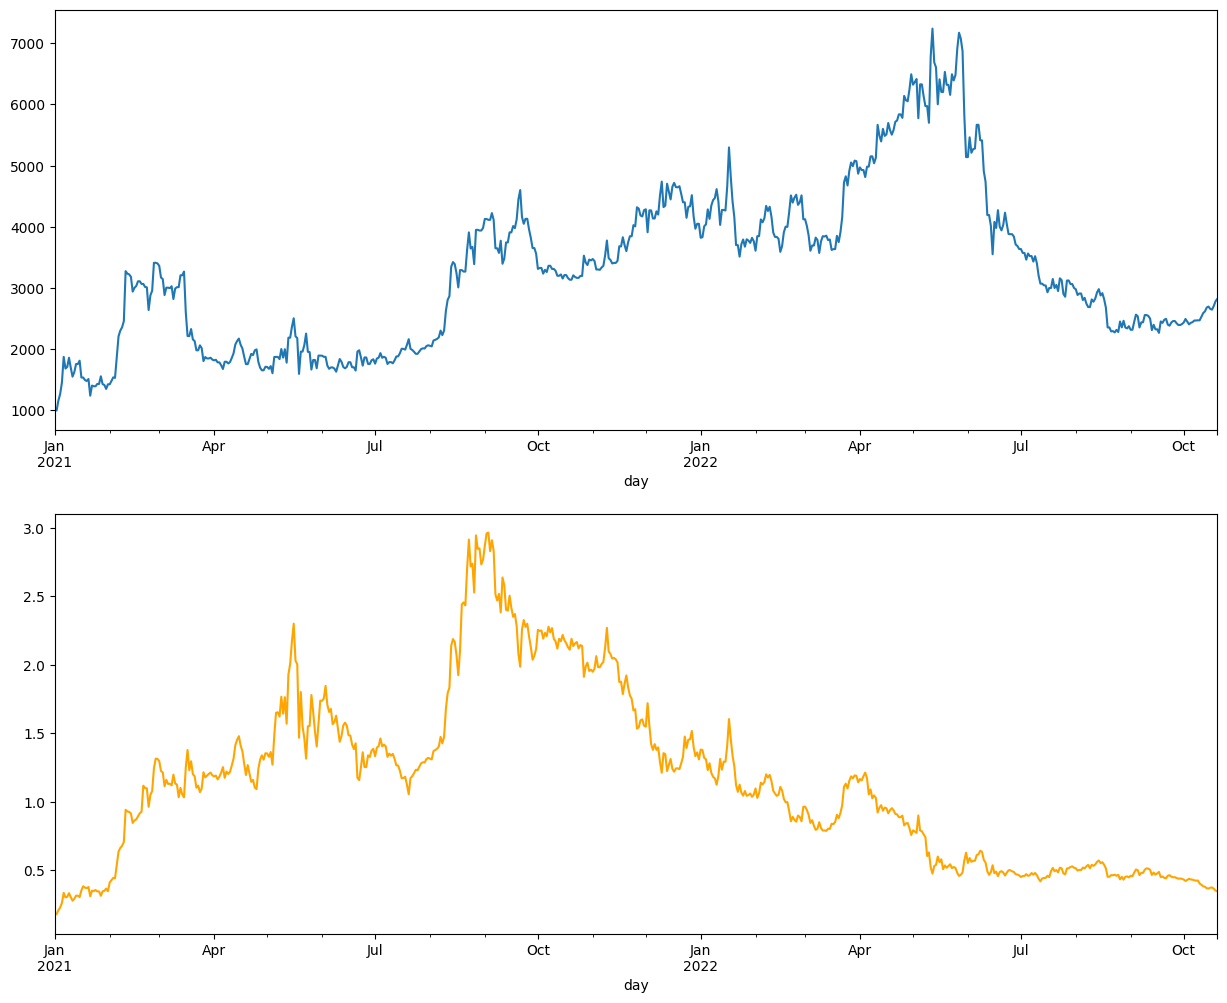

In [25]:
dt = df.copy().loc["2021":]

strat = lstm_strat(
    df=dt,
    use_short=True,
    strat=0,
)

strat.populate_indicators()
strat.populate_buy_sell(show_log=False)
bt_result = strat.run_backtest(initial_wallet=1000, return_type="metrics")
df_trades, df_days = basic_single_asset_backtest(
    trades=bt_result["trades"], days=bt_result["days"]
)
plot_wallet_vs_asset(df_days=bt_result["days"])



Open LONG length : 331
Close LONG length : 325
Open SHORT length : 0
Close SHORT length : 0
Period: [2021-01-01 00:00:00] -> [2022-10-20 00:00:00]
Initial wallet: 1000.0 $

--- General Information ---
Final wallet: 2474.13 $
Performance vs US dollar: 147.41 %
Sharpe Ratio: 0.99
Worst Drawdown T|D: -69.64% | -71.25%
Buy and hold performance: 96.24 %
Performance vs buy and hold: 26.08 %
Total trades on the period: 172
Global Win rate: 56.4 %
Average Profit: 1.0 %

Best trades: +87.54 % the 2021-01-02 00:00:00 -> 2021-01-06 00:00:00
Worst trades: -26.68 % the 2022-06-09 00:00:00 -> 2022-06-13 00:00:00


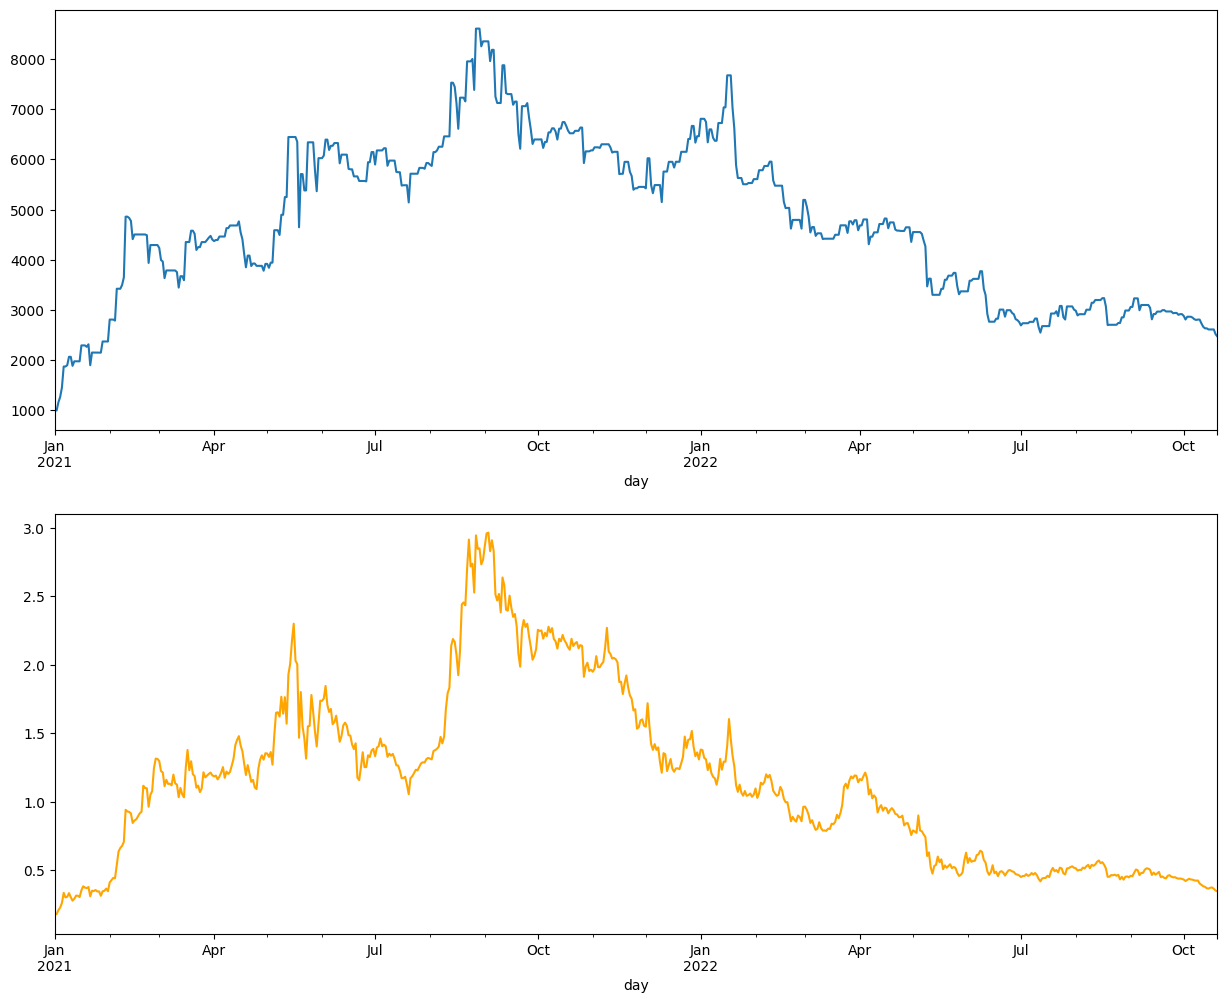

In [26]:

dt = df.copy().loc["2021":]

strat = lstm_strat(
    df=dt,
    use_short=False,
    strat=1,
)

strat.populate_indicators()
strat.populate_buy_sell(show_log=True)
bt_result = strat.run_backtest(initial_wallet=1000, return_type="metrics")
df_trades, df_days = basic_single_asset_backtest(
    trades=bt_result["trades"], days=bt_result["days"]
)
plot_wallet_vs_asset(df_days=bt_result["days"])